# Portfolio Analyzer

**Author:** Yusuf Ardahan Dogru  
**Date:** December 2025  
**Purpose:** Analyze multi-asset portfolios using Modern Portfolio Theory

## Overview
This notebook explores implementations and outcomes of portfolio optimization techniques that the author is curious about; including:
- Risk-return analysis
- Minimum variance optimization
- Sharpe ratio maximization

The notebook also contains the XGBoost model to forecast stock values

### Library Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


### Style of Visualization

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Stock and ETF tickers

In [3]:
tickers = [
    # Individual stocks (play around with different stocks)
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', # 4 of the Magnificient 7
    'JPM', 'BAC',                    # finance/banking giants
    'WMT', 'AMZN',                   # retail giants ( + 1 Magnif 7)
    'JNJ', 'UNH',                    # healthcare
    'XOM', 'CVX',                    # oil
    
    # Strategic ETFs
    'SCHG',  # Growth
    'SPMO',  # Momentum
    'SMH',   # Semiconductors
    
    # Benchmarks
    'SPY',   # S&P 500
    'AGG'    # Bonds (consider for diversification)
]

### Get ticker data using yf

In [4]:
start_date = '2022-12-01'
end_date = '2024-12-01'

# auto_adjust=True => modifies historical stock prices so that stock splits and dividends do not artificially distort returns
# progress=False => this just removes the progress bar, just a visual setting
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)  


if isinstance(raw_data.columns, pd.MultiIndex):
    data = raw_data['Close'].copy()
else:
    data = raw_data.copy()

print(f"Data shape: {data.shape}")
print(f"Date range: From {data.index[0].date()} to {data.index[-1].date()}")

Data shape: (502, 17)
Date range: From 2022-12-01 to 2024-11-29


### Handle Missing Values

In [5]:
if (data.isnull().sum()).sum() > 0:
    print(f"\nMissing values per stock:")
    print(data.isnull().sum())
    data = data.ffill()  
# ffill => forward fill => replace with last/preceding val

if len(data) < 100:
    print(f"Warning: Only {len(data)} days of data available")

In [6]:
returns = data.pct_change().dropna()
#pct_change is a pandas Dataframe method, computes: (current_value - previous_value) / previous_value for each column, row by row

print("Daily returns calculated!")
print(f"Shape: {returns.shape}")
print(f"\nSample returns:")
print(returns.head(1))

# Calculate key metrics
annual_returns = returns.mean() * 252  # 252 trading days per year
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = annual_returns / annual_volatility

# Create summary DataFrame
metrics_df = pd.DataFrame({
    'Annual Return (%)': (annual_returns * 100).round(2),
    'Volatility (%)': (annual_volatility * 100).round(2),
    'Sharpe Ratio': sharpe_ratio.round(3)
}).sort_values('Sharpe Ratio', ascending=False)

print("\n" + "="*60)
print("PORTFOLIO METRICS SUMMARY")
print("="*60)
print(metrics_df)

Daily returns calculated!
Shape: (501, 17)

Sample returns:
Ticker          AAPL       AGG      AMZN       BAC    CVX     GOOGL       JNJ  \
Date                                                                            
2022-12-02 -0.003371  0.004146 -0.014346 -0.012859 -0.008 -0.005446  0.000783   

Ticker           JPM      MSFT      NVDA      SCHG       SMH      SPMO  \
Date                                                                     
2022-12-02 -0.007927  0.001296 -0.015115 -0.002962 -0.013744  0.001365   

Ticker           SPY       UNH       WMT       XOM  
Date                                                
2022-12-02 -0.001153  0.001681 -0.000978 -0.008484  

PORTFOLIO METRICS SUMMARY
        Annual Return (%)  Volatility (%)  Sharpe Ratio
Ticker                                                 
NVDA               118.09           51.32         2.301
WMT                 32.67           16.69         1.958
SCHG                32.44           17.58         1.846
SPMO   

### Check Correlations of Stock With Each Other

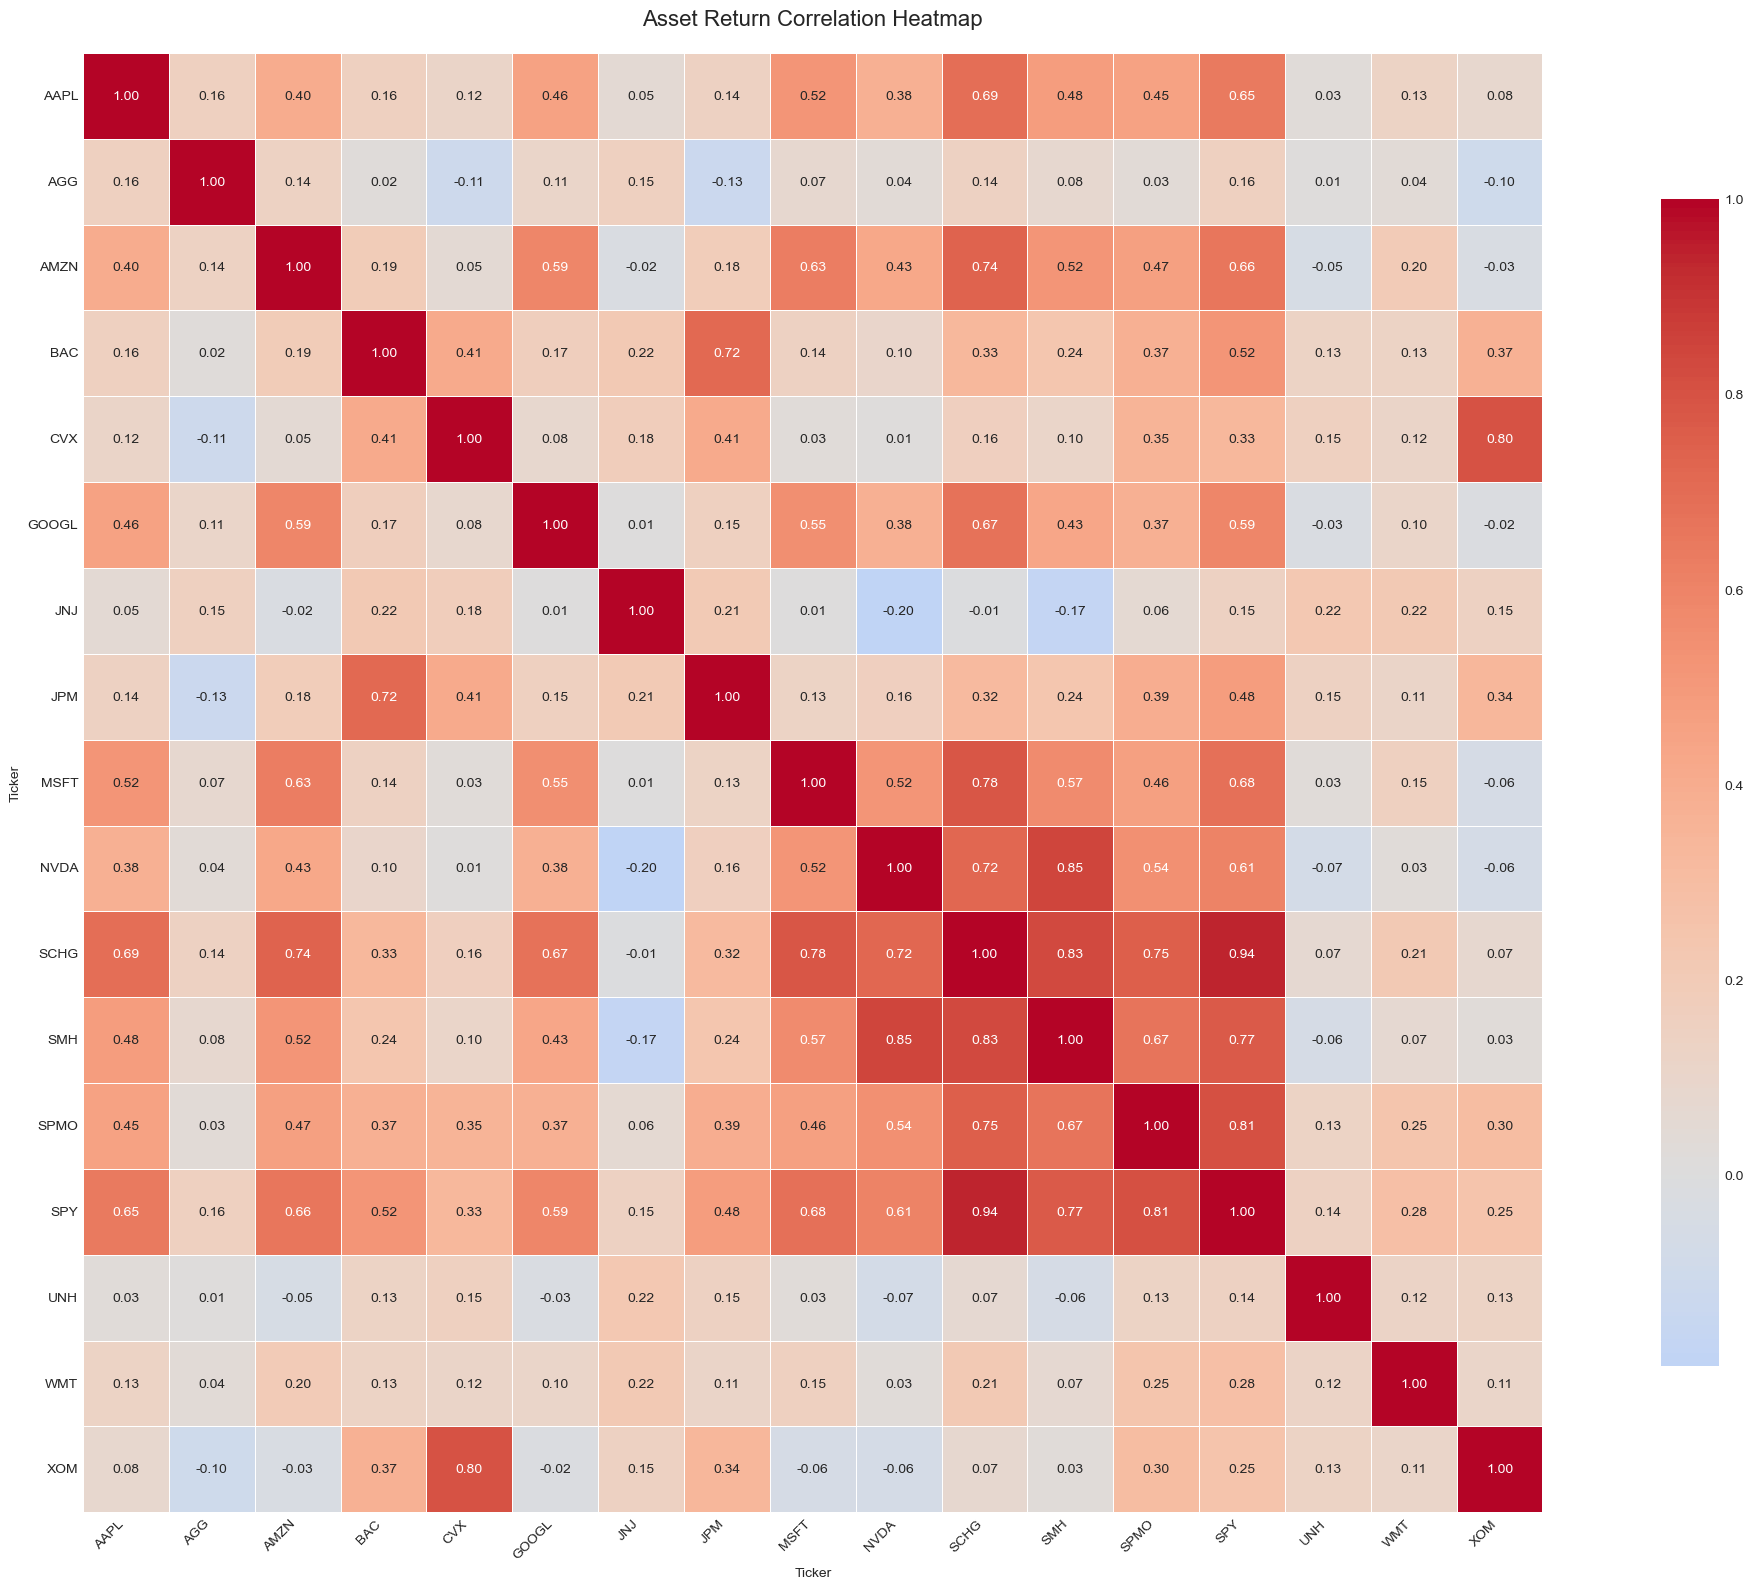

In [7]:
corr_matrix = returns.corr()

plt.figure(figsize=(24, 16))  # Larger figure
sns.heatmap(corr_matrix, 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5,
            annot=True,  # Show correlation values
            fmt='.2f',   # 2 decimal places
            square=True, # Make cells square
            cbar_kws={'shrink': 0.8})  # Smaller colorbar
plt.title('Asset Return Correlation Heatmap', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.yticks(rotation=0)
plt.tight_layout()  # Prevent label cutoff
plt.show()

## Construct a fair portfolio (equal allocation in the porfolio for each ticker)

In [8]:
riskFreeRate = 0.04 # 3 month T-bills as the risk-free benchmark.

num_assets = returns.shape[1] #num of stock tickers
equal_weights = np.array([1 / num_assets] * num_assets) #equal weights that add upto one

portfolio_returns_fair = returns @ equal_weights # daily returns of fairly allocated portfolio ( 1 / numStocks)

portfolio_vol_fair = portfolio_returns_fair.std() * np.sqrt(252)  # avg daily standard deviation * 252 for annualized volatility
portfolio_return_fair = portfolio_returns_fair.mean() * 252 # avg daily return * 252 to annualize
portfolio_sharpe_fair = portfolio_return_fair / portfolio_vol_fair

## Optimize Fair Portfolio 

In [9]:
cov_matrix = returns.cov() * 252

def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix.values @ weights)

# sum of weights must be equal to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

#each weight is between 0 and 1; a percentage of the portfolio
bounds = tuple((0, 1) for _ in range(num_assets))

from scipy.optimize import minimize

initial_weights = equal_weights

# minimize portfolio volatility using initial weights according to SLSQP method with bounds within 0 and 1 and the constraint above
opt_result = minimize(
    portfolio_volatility,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weights = opt_result.x
print(opt_weights)

[0.00000000e+00 7.23905657e-01 0.00000000e+00 0.00000000e+00
 2.46774812e-02 0.00000000e+00 2.68902020e-02 4.66148279e-02
 2.42955579e-02 4.53725789e-18 2.92487836e-19 0.00000000e+00
 2.45700658e-02 0.00000000e+00 3.04554994e-02 6.59822192e-02
 3.26084900e-02]


In [10]:
portfolio_returns_opt = returns @ opt_weights

portfolio_vol_opt = portfolio_returns_opt.std() * np.sqrt(252)
portfolio_return_opt = portfolio_returns_opt.mean() * 252
portfolio_sharpe_opt = portfolio_return_opt / portfolio_vol_opt

print(portfolio_sharpe_opt)
print(portfolio_return_opt)
print(portfolio_vol_opt)

1.4960220040508136
0.08394307641332671
0.056110856782876244


### Risk - Return Results

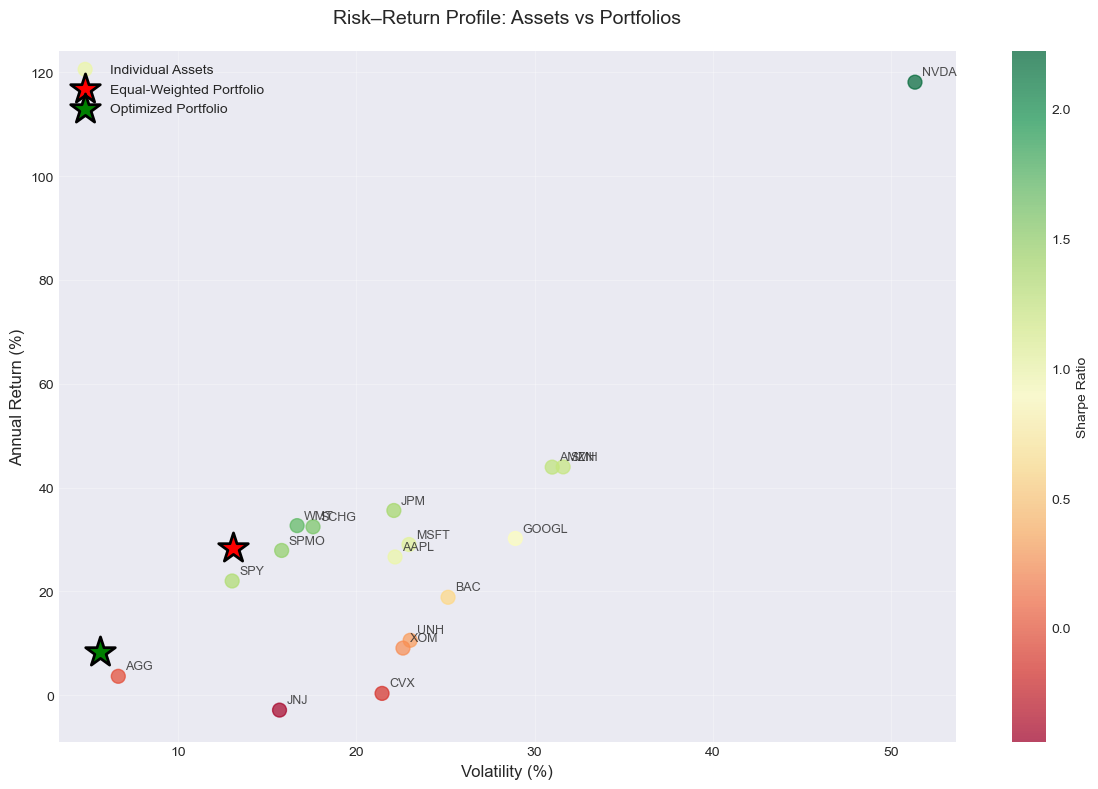

In [11]:
sharpe_ratio = (annual_returns - riskFreeRate) / annual_volatility

# Create the plot
plt.figure(figsize=(12, 8))

# Plot individual assets
plt.scatter(
    annual_volatility * 100,
    annual_returns * 100,
    s=100,
    alpha=0.7,
    c=sharpe_ratio,  # Color by Sharpe ratio
    cmap='RdYlGn',   # Red (low) to Green (high)
    label='Individual Assets'
)
plt.colorbar(label='Sharpe Ratio')

# Annotate each ticker
for ticker in tickers:
    plt.annotate(
        ticker,
        xy=(annual_volatility[ticker] * 100, annual_returns[ticker] * 100),
        xytext=(5, 5),  # Offset the label slightly
        textcoords='offset points',
        fontsize=9,
        alpha=0.8
    )

# Plot portfolios
plt.scatter(
    portfolio_vol_fair * 100,
    portfolio_return_fair * 100,
    marker='*',
    s=500,
    c='red',
    edgecolors='black',
    linewidths=2,
    label='Equal-Weighted Portfolio',
    zorder=5  # Draw on top
)

plt.scatter(
    portfolio_vol_opt * 100,
    portfolio_return_opt * 100,
    marker='*',
    s=500,
    c='green',
    edgecolors='black',
    linewidths=2,
    label='Optimized Portfolio',
    zorder=5
)

plt.xlabel('Volatility (%)', fontsize=12)
plt.ylabel('Annual Return (%)', fontsize=12)
plt.title('Risk–Return Profile: Assets vs Portfolios', fontsize=14, pad=20)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



##  1: Feature Engineering

### Create predictive features from historical data:

In [12]:
def create_features(data, returns, ticker):

    df = pd.DataFrame(index=returns.index)
    print(df.columns)
    # Momentum 
    df['return_5d'] = returns[ticker].rolling(5).mean()
    df['return_20d'] = returns[ticker].rolling(20).mean()
    df['return_60d'] = returns[ticker].rolling(60).mean()
    
    # Volatility 
    df['volatility_20d'] = returns[ticker].rolling(20).std()
    df['volatility_60d'] = returns[ticker].rolling(60).std()
    
    # Volume  (if available)
    # df['volume_ratio'] = volume[ticker] / volume[ticker].rolling(20).mean()
    
    # Market correlation 
    df['corr_to_spy'] = returns[ticker].rolling(60).corr(returns['SPY'])
    
    # Relative strength
    df['rsi_14'] = calculate_rsi(returns[ticker], periods=14)
    
    return df.dropna()

# Answers the question: How strong are the gains compared to the losses over a period?
# also a momentum indicator 
def calculate_rsi(returns, periods=14):
    delta = returns
    gain = (delta.where(delta > 0, 0)).rolling(window = periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window = periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

### Create target variable (in this case, SPY)

In [13]:
def create_target(returns, ticker, forward_window=20):
    """
    Will this stock outperform SPY in next 20 days? => 1 if yes, 0 if no
    """
    # forward returns
    forward_return_stock = returns[ticker].shift(-forward_window).rolling(forward_window).sum()
    forward_return_spy = returns['SPY'].shift(-forward_window).rolling(forward_window).sum()
    
    target = (forward_return_stock > forward_return_spy).astype(int)
    
    return target

### Combine Features & Target

In [14]:
# For each stock, create dataset
all_data = []

for ticker in [t for t in tickers if t not in ['SPY', 'QQQ']]:
    features = create_features(data, returns, ticker)
    target = create_target(returns, ticker, forward_window=20)
    
    # Combine
    stock_data = features.copy()
    stock_data['target'] = target
    stock_data['ticker'] = ticker
    stock_data.dropna(inplace=True)
    
    all_data.append(stock_data)

# Combine all stocks
ml_dataset = pd.concat(all_data, axis=0)

RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)


### Time-based Train-Test Split 

In [15]:
from datetime import timedelta

end_date = pd.to_datetime(end_date)  # Your end_date variable
test_days = 120  # Last 120 days for testing
split_date = end_date - pd.Timedelta(days=test_days)

train = ml_dataset[ml_dataset.index < split_date]
test = ml_dataset[ml_dataset.index >= split_date]

X_train = train.drop(['target', 'ticker'], axis=1)
y_train = train['target']

X_test = test.drop(['target', 'ticker'], axis=1)
y_test = test['target']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Positive class %: {y_train.mean():.2%}")

Training samples: 5744
Test samples: 1328
Positive class %: 53.52%


## Training

In [16]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

#### Competitor Models

In [17]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred)

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred)

#### XGBoost

In [18]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred)

# Compare
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [lr_auc, rf_auc, xgb_auc]
}).sort_values('ROC-AUC', ascending=False)

print(results)

                 Model   ROC-AUC
0  Logistic Regression  0.616427
2              XGBoost  0.581618
1        Random Forest  0.580466


## Validation

Top 5 Features:
          Feature  Importance
4  volatility_60d    0.217109
5     corr_to_spy    0.182181
2      return_60d    0.142232
3  volatility_20d    0.142177
6          rsi_14    0.115741
              precision    recall  f1-score   support

           0       0.70      0.33      0.45       829
           1       0.41      0.77      0.53       499

    accuracy                           0.49      1328
   macro avg       0.55      0.55      0.49      1328
weighted avg       0.59      0.49      0.48      1328



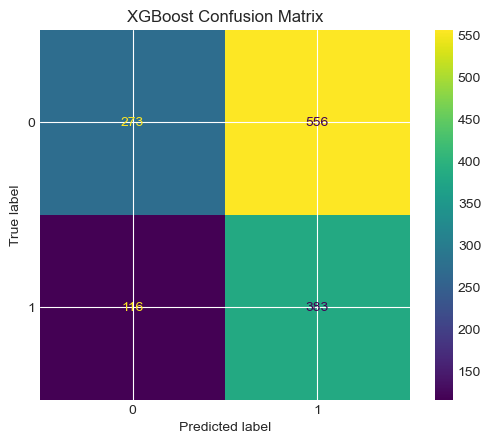

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 5 Features:")
print(feature_importance.head())

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb.predict(X_test)))

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title('XGBoost Confusion Matrix')
plt.show()

### Use Predictions for Portfolio

In [20]:
# Get current predictions for each stock
current_features = {}
for ticker in [t for t in tickers if t not in ['SPY', 'QQQ']]:
    features = create_features(data, returns, ticker)
    current_features[ticker] = features.iloc[-1:] # Most recent

# Predict outperformance probability
predictions = {}
for ticker, feats in current_features.items():
    prob = xgb.predict_proba(feats)[:, 1][0]
    predictions[ticker] = prob

# Create ML-based weights
ml_weights = pd.Series(predictions)
ml_weights = ml_weights / ml_weights.sum()  # Normalize to sum to 1

print("ML-Based Portfolio Weights:")
print(ml_weights.sort_values(ascending=False))

RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
RangeIndex(start=0, stop=0, step=1)
ML-Based Portfolio Weights:
NVDA     0.112484
MSFT     0.087586
SMH      0.076029
AAPL     0.072127
BAC      0.070774
SPMO     0.069175
JPM      0.068890
JNJ      0.067438
UNH      0.066110
SCHG     0.061159
GOOGL    0.060833
CVX      0.047628
AGG      0.039101
XOM      0.034020
WMT      0.033864
AMZN     0.032784
dtype: float32


## Backtest ML Portfolio

In [21]:
# Calculate ML portfolio returns
ml_portfolio_returns = test_returns @ ml_weights

# Compare to benchmarks
comparison = pd.DataFrame({
    'ML Portfolio': [
        ml_portfolio_returns.mean() * 252,
        ml_portfolio_returns.std() * np.sqrt(252),
        (ml_portfolio_returns.mean() * 252) / (ml_portfolio_returns.std() * np.sqrt(252))
    ],
    'Equal Weight': [
        portfolio_return_fair,
        portfolio_vol_fair,
        portfolio_sharpe_fair
    ],
    'Min Variance': [
        portfolio_return_opt,
        portfolio_vol_opt,
        portfolio_sharpe_opt
    ]
}, index=['Annual Return', 'Volatility', 'Sharpe Ratio'])

print(comparison)

NameError: name 'test_returns' is not defined

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation of PRICES (high)
plot_acf(data['AAPL'].dropna(), lags=30)
plt.title('Autocorrelation: AAPL Prices')
plt.show()

# Autocorrelation of RETURNS (low)
plot_acf(returns['AAPL'].dropna(), lags=30)
plt.title('Autocorrelation: AAPL Returns')
plt.show()